In [126]:
import torch, torch.nn as nn, torch.utils.data as data, torch.nn.functional as F
from torch.autograd import grad
import lightning as L
import numpy as np
import matplotlib.pyplot as plt

In [128]:
class ODE_Learner(L.LightningModule):
    def __init__(self, init_condition, gamma):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 50),
            nn.GELU(),
            nn.Linear(50, 100),
            nn.GELU(),
            nn.Linear(100, 500),
            nn.GELU(),
            nn.Linear(500, 500),
            nn.GELU(),
            nn.Linear(500, 500),
            nn.GELU(),
            nn.Linear(500, 500),
            nn.GELU(),
            nn.Linear(500, 100),
            nn.GELU(),
            nn.Linear(100, 50),
            nn.GELU(),
            nn.Linear(50, 1),
        )
        self.init_condition = init_condition
        self.gamma = gamma

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adadelta(self.parameters())

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x.requires_grad = True

        g_t = self.init_condition + x * self.forward(x)
        # sol = self.gamma * g_t
        sol = 2 * x
        dgt_dx = grad(
            retain_graph=True, outputs=g_t, inputs=x, grad_outputs=torch.ones_like(x)
        )[0]

        loss = nn.MSELoss()(dgt_dx, sol)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

In [129]:
class Dataset(data.Dataset):

    def __init__(self, init, end, n):

        self.n = n
        self.x = torch.linspace(init, end, self.n)
        # self.y = 10 * np.exp(2 * self.x)
        self.y = 10 + self.x**2

    def __len__(self):
        return self.n

    def __getitem__(self, idx):

        x = self.x[idx, np.newaxis]
        y = self.y[idx, np.newaxis]

        return torch.Tensor(x), torch.Tensor(y)

In [130]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

train = Dataset(0, 1, 1000)


early_stop_callback = EarlyStopping(
    monitor="train_loss",
    min_delta=0,
    patience=10000000,
    verbose=False,
    mode="min",
    stopping_threshold=1,
)


trainer = L.Trainer(logger=False, max_epochs=200000, callbacks=[early_stop_callback])


learner = ODE_Learner(10, 2)


trainer.fit(learner, data.DataLoader(train, batch_size=100))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\zheyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:653: Checkpoint directory c:\Users\zheyu\OneDrive\Documents\GitHub\Senior-Project\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 862 K 
-------------------------------------
862 K     Trainable params
0         Non-trainable params
862 K     Total params
3.450     Total estimated model params size (MB)
c:\Users\zheyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in t

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\zheyu\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


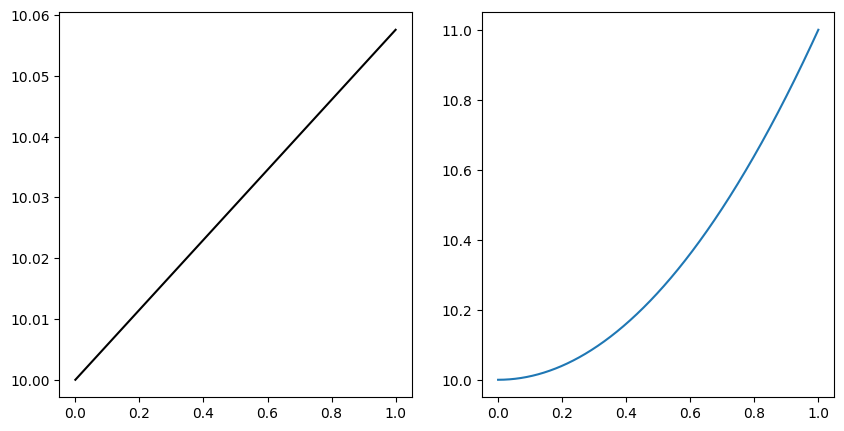

In [133]:
y = learner.model.forward(train.x.view(1000, 1).to("cuda"))
y = y.detach().cpu()


fig = plt.figure(figsize=(10, 5))


ax = fig.add_subplot(121)


ax.plot(train.x, 10 + train.x * y.flatten(), color="black")


ax1 = fig.add_subplot(122)
ax1.plot(train.x, train.y)